<a href="https://colab.research.google.com/github/RaianaSeixas/Relevant_Job_Title_Pictures_NLP/blob/main/Relevant_Job_Title_Pictures_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Determining Relevant Job Title Pictures**
The objective of this short project is to automatically find relevant pictures for job titles. We are looking for pictures that represent the activities typically associated with that job title, showing people or tools used on the job.
## Dataset
The dataset provided is a .csv file with a set of pictures queried from Google Images, with the following available metadata and pre-extracted features:

* Job Title: the job we are trying to get pictures for.

* Pic Title: the picture title according to Google Images.

* Num Resumes: the number of resumes we have available for the job title. This indicates how popular /common the job title is.

* Google Position: the position of the image in the search results.

* Strict Face Count: face count according to a high-precision face recognition algorithm from OpenCV. When it detects a face, it is a human face almost 100% of the time, but it doesn't detect all human faces.

* Relaxed Face Count: face count according to a high-recall face recognition algorithm from OpenCV. It detects human faces almost 100% of the time, but it also confuses some other shapes and objects with human faces.

* KB size: size of the image in kilobytes.

* Height: pixel height of the image.

* Width: pixel width of the image.

* Resolution: total pixels in the image.

* Text regions: number of text regions identified in the image, also using OpenCV.

* Picture URL: the URL of the image.

* Manual Label: a label indicating if the picture is good (relevant) or bad (irrelevant). 

##Methodology

#####The feature "Manual Label" is available only for  around 20% of the dataset. For this reason, I decided to use unsupervised learning to create the model and use the labaled data to evaluate the quality of the model.
----------
Author: Raiana Roland Seixas
09/07/2022

# Data load & Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
import nltk
ps = nltk.PorterStemmer()
wn=nltk.WordNetLemmatizer()
nltk.download("popular")
stopwords = nltk.corpus.stopwords.words('english')
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [ ]:
from google.colab import files

In [ ]:
!git clone https://github.com/RaianaSeixas/NLT
%cd NLT

fatal: destination path 'NLT' already exists and is not an empty directory.
/content/NLT/NLT/NLT/NLT/NLT/NLT/NLT/NLT


In [ ]:
df=pd.read_csv('occupation_pictures.csv')
df

,Job Title,Pic Title,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,KB size,Height,Width,Resolution,Text Regions,Picture URL,Manual Label
0,3D Modeler,Our Top 19 3D Modeling Software Picks ...,1261,0,0,7,276.763672,1917,2301,4411017,2,https://format-magazine-production-res.cloudin...,NaN
1,3D Modeler,7 Tips for Beginner 3D Modelers ...,1261,1,0,3,44.343750,340,747,253980,5,http://static1.squarespace.com/static/5320f582...,NaN
2,3D Modeler,How to Become an Expert 3D Modeler ...,1261,2,0,2,43.088867,380,660,250800,8,https://www.gamedesigning.org/wp-content/uploa...,NaN
3,3D Modeler,What is 3D Modeling & What's It Used For?,1261,3,0,2,78.623047,330,750,247500,1,https://cdn.conceptartempire.com/images/04/522...,NaN
4,3D Modeler,Shoofping 3D Modeler ...,1261,4,0,1,97.517578,1075,1909,2052175,3,http://shoofping.com/wp-content/uploads/2017/1...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,Wind Turbine Engineer,Wind turbine technician fastest-growing ...,61,4,0,0,89.249023,720,1280,921600,0,https://i.ytimg.com/vi/lUf2mOYp1d4/maxresdefau...,good
654,Wind Turbine Engineer,How to Become a Wind Energy Engineer ...,61,5,0,0,37.949219,200,300,60000,0,https://www.environmentalscience.org/wp-conten...,NaN
655,Wind Turbine Engineer,Wind - Get Into Energy,61,6,0,1,324.730469,500,750,375000,1,http://getintoenergy.com/wp-content/uploads/20...,good
656,Wind Turbine Engineer,Wind-energy programs yield engineering ...,61,7,0,1,36.197266,920,613,563960,0,https://s.hdnux.com/photos/20/15/22/4248747/3/...,good


In [ ]:
data=df.drop(columns=['Picture URL'])

# Exploratory Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Job Title           658 non-null    object 
 1   Pic Title           658 non-null    object 
 2   Num Resumes         658 non-null    int64  
 3   Google Position     658 non-null    int64  
 4   Strict Face Count   658 non-null    int64  
 5   Relaxed Face Count  658 non-null    int64  
 6   KB size             658 non-null    float64
 7   Height              658 non-null    int64  
 8   Width               658 non-null    int64  
 9   Resolution          658 non-null    int64  
 10  Text Regions        658 non-null    int64  
 11  Picture URL         658 non-null    object 
 12  Manual Label        133 non-null    object 
dtypes: float64(1), int64(8), object(4)
memory usage: 67.0+ KB


In [ ]:
df.describe()

,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,KB size,Height,Width,Resolution,Text Regions
count,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,658.000000,6.580000e+02,658.000000
mean,8816.180851,3.943769,0.120061,2.253799,277.716200,740.530395,922.664134,1.118206e+06,27.214286
std,33341.824305,2.545453,0.377275,7.609237,1242.427515,614.577054,804.401280,2.911348e+06,43.149501
min,9.000000,0.000000,0.000000,0.000000,6.150391,135.000000,189.000000,3.000000e+04,0.000000
25%,747.000000,2.000000,0.000000,0.000000,44.422852,396.500000,573.750000,2.440730e+05,0.000000
50%,1710.000000,4.000000,0.000000,1.000000,76.358887,628.000000,640.000000,4.823520e+05,3.000000
75%,4642.000000,6.000000,0.000000,2.000000,135.501221,842.000000,1000.000000,7.345628e+05,37.750000
max,347272.000000,8.000000,3.000000,142.000000,18082.060550,4449.000000,6048.000000,2.438554e+07,246.000000


In [ ]:
df['Manual Label'].describe()

count      133
unique       2
top       good
freq        91
Name: Manual Label, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81f6f14690>,
      dtype=object)

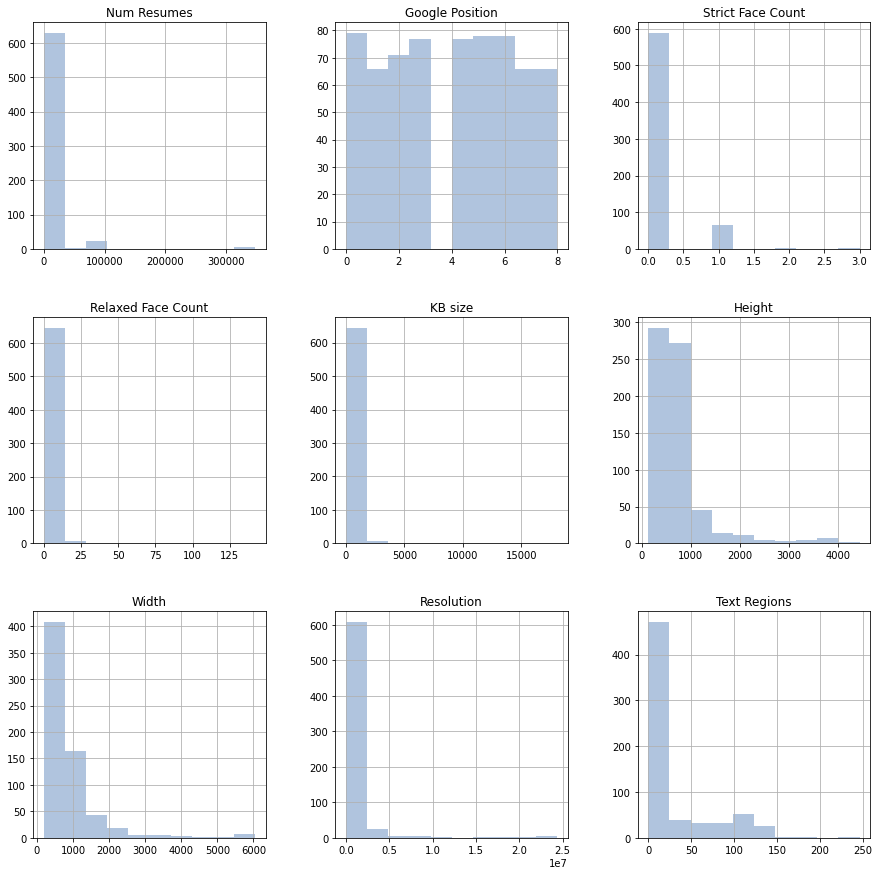

In [ ]:
df.hist(figsize=(15,15), color='lightsteelblue')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Images count by label')

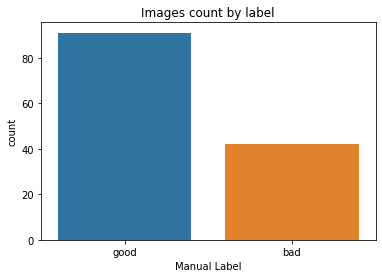

In [ ]:
sns.countplot(df['Manual Label'])
plt.title('Images count by label')

Labeled data is umbalanced. F1-score is a good quality metric in this context.


Text(0.5, 1.0, 'Boxplot Num Resumes by label')

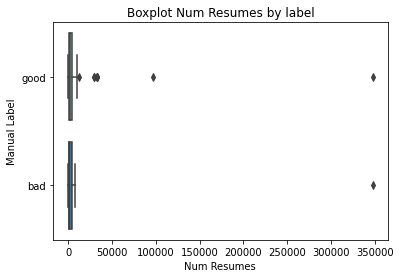

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Num Resumes', data = df,  palette="Paired")
plt.title('Boxplot Num Resumes by label')

Text(0.5, 1.0, 'Boxplot Google Position by label')

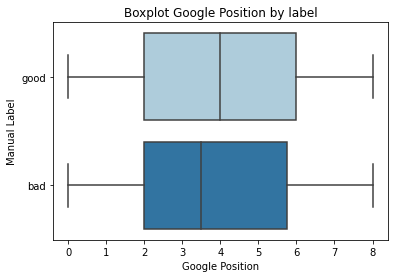

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Google Position', data = df,  palette="Paired")
plt.title('Boxplot Google Position by label')

Text(0.5, 1.0, 'Boxplot Strict Face Count by label')

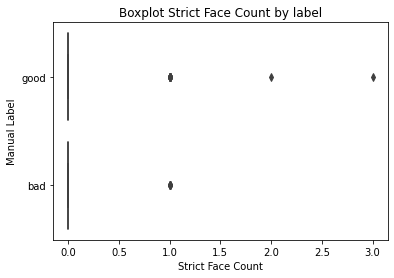

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Strict Face Count', data = df,  palette="Paired")
plt.title('Boxplot Strict Face Count by label')

Text(0.5, 1.0, 'Boxplot Relaxed Face Count by label')

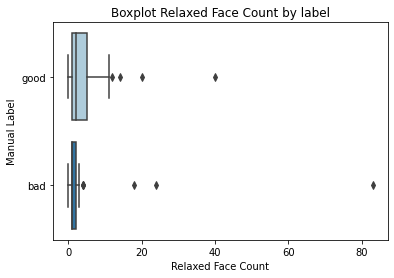

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Relaxed Face Count', data = df,  palette="Paired")
plt.title('Boxplot Relaxed Face Count by label')

Text(0.5, 1.0, 'Boxplot KB size by label')

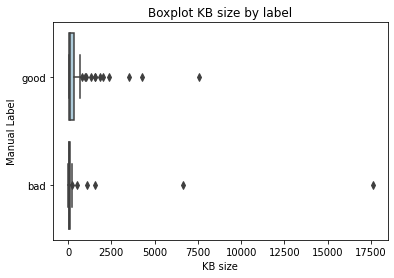

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'KB size', data = df,  palette="Paired")
plt.title('Boxplot KB size by label')

Text(0.5, 1.0, 'Boxplot Height by label')

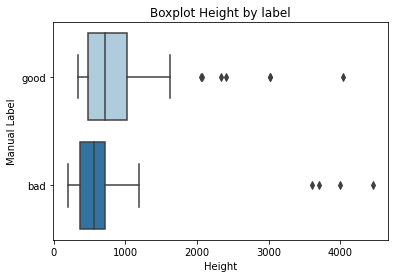

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Height', data = df,  palette="Paired")
plt.title('Boxplot Height by label')

Text(0.5, 1.0, 'Boxplot Width by label')

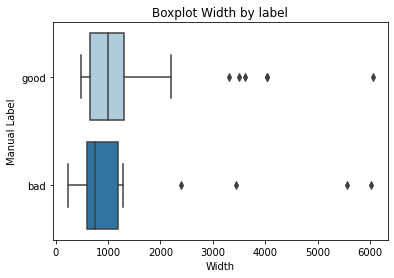

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Width', data = df,  palette="Paired")
plt.title('Boxplot Width by label')

Text(0.5, 1.0, 'Boxplot Resolution by label')

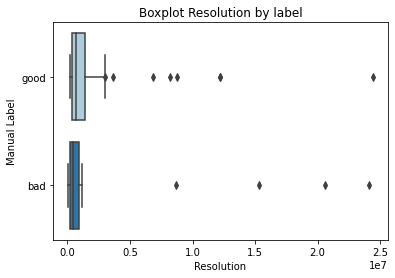

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Resolution', data = df,  palette="Paired")
plt.title('Boxplot Resolution by label')

Text(0.5, 1.0, 'Boxplot Text Regions by label')

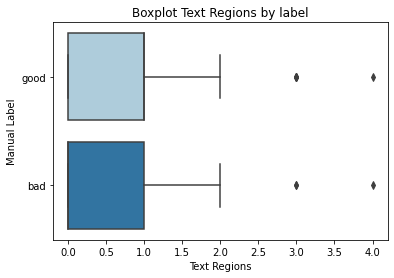

In [ ]:
sns.boxplot(y = 'Manual Label', x = 'Text Regions', data = df,  palette="Paired")
plt.title('Boxplot Text Regions by label')

# Data Transformation

### Clean up text

In [ ]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

data['Job Title'] = data['Job Title'].apply(lambda x: clean_text(x.lower()))
data['Pic Title'] = data['Pic Title'].apply(lambda x: clean_text(x.lower()))
#data.head()

### Stem Text

In [ ]:
def stemming(text):
  stemmed=[ps.stem(word) for word in text]
  return stemmed

data['Stem Job Title'] = data['Job Title'].apply(lambda x: stemming(x))
data['Stem Pic Title'] = data['Pic Title'].apply(lambda x: stemming(x))
#data

In [ ]:
#data[data['Manual Label']=='bad']

In [ ]:
#data[data['Manual Label']=='good']

In [ ]:
data.head()

,Job Title,Pic Title,Num Resumes,Google Position,Strict Face Count,Relaxed Face Count,KB size,Height,Width,Resolution,Text Regions,Manual Label,Stem Job Title,Stem Pic Title
0,"[3d, modeler]","[top, 19, 3d, modeling, software, picks, ]",1261,0,0,7,276.763672,1917,2301,4411017,2,NaN,"[3d, model]","[top, 19, 3d, model, softwar, pick, ]"
1,"[3d, modeler]","[7, tips, beginner, 3d, modelers, ]",1261,1,0,3,44.343750,340,747,253980,5,NaN,"[3d, model]","[7, tip, beginn, 3d, model, ]"
2,"[3d, modeler]","[become, expert, 3d, modeler, ]",1261,2,0,2,43.088867,380,660,250800,8,NaN,"[3d, model]","[becom, expert, 3d, model, ]"
3,"[3d, modeler]","[3d, modeling, whats, used]",1261,3,0,2,78.623047,330,750,247500,1,NaN,"[3d, model]","[3d, model, what, use]"
4,"[3d, modeler]","[shoofping, 3d, modeler, ]",1261,4,0,1,97.517578,1075,1909,2052175,3,NaN,"[3d, model]","[shoofp, 3d, model, ]"


## Feature engineering
Droping not important features (texted one by one) and adding the new features to create the entrance for the model

### Feature Selection

In [ ]:
data.columns

Index(['Job Title', 'Pic Title', 'Num Resumes', 'Google Position',
       'Strict Face Count', 'Relaxed Face Count', 'KB size', 'Height', 'Width',
       'Resolution', 'Text Regions', 'Manual Label', 'Stem Job Title',
       'Stem Pic Title'],
      dtype='object')

In [ ]:
X = data.drop(columns=['Manual Label','Job Title','Pic Title','Stem Job Title','Stem Pic Title']) # not numeric features
X = X.drop(columns=['KB size','Resolution','Width','Google Position', 'Relaxed Face Count','Num Resumes' ]) # features that  disturb the model
# 'Strict Face Count' 'Text Regions',''Height',

### Proportion of words in Job Title that appear in Pic Title

In [ ]:
arr1 = data['Stem Job Title'].values 
arr2 = data['Stem Pic Title'].values 
n = arr1.shape[0] # n = 658
lista = []
divide = []
for i in range(n):
  aux =0
  c1 = list(arr1[i])
  for x in arr1[i]:
    c2 = list(arr2[i])
    if(c2.count(x) != 0):
      aux = aux + 1
  lista.append(aux)
  try:
   divide.append(aux/len(c1))
  except:
   divide.append(0)
#print(lista)
#print(divide)

In [ ]:
X['Proportion']=divide
W = X.copy()
X

,Strict Face Count,Height,Text Regions,Proportion
0,0,1917,2,1.000000
1,0,340,5,1.000000
2,0,380,8,1.000000
3,0,330,1,1.000000
4,0,1075,3,1.000000
...,...,...,...,...
653,0,720,0,0.666667
654,0,200,0,0.666667
655,0,500,1,0.333333
656,0,920,0,0.333333


In [ ]:
W['Proportion'].describe()

count    658.000000
mean       0.734549
std        0.341902
min        0.000000
25%        0.500000
50%        1.000000
75%        1.000000
max        1.000000
Name: Proportion, dtype: float64

### Create Clusteres to agregate Job Title and Pic Title
The model was trained with all points of Pic Title and Job Title together. 2 new column were created, one whose entrance are the tokens of Job Title and the other whose entrance are the tokens of Pic Title.
Both BIRCH and K-means were used to group the text data, andin the end, one of them was selected.

In [ ]:
documents = data['Stem Pic Title'].values
job = data['Stem Job Title'].values
corpus = job + documents 

In [ ]:
# Function using K-means

def text_variable(corpus,documents,cluster_k):
  def lista_organiza(arr_conv):
    n = arr_conv.shape[0]
    lista =[]
    for i in range(n):
      arr = arr_conv[i]
      ans =' '.join(arr)
      lista.append(ans)
    resp = lista
    return resp  

  corpus = lista_organiza(corpus)
  documents = lista_organiza(documents)

  vectorizer = TfidfVectorizer()
  XW = vectorizer.fit_transform(corpus)

  model = KMeans(n_clusters=cluster_k, init='k-means++', max_iter=100, n_init=1)
  model.fit(XW)
  resp = []
  for x in documents:
    doc=[]
    doc.append(x)
    Y = vectorizer.transform(doc)
    prediction = model.predict(Y)
    resp.append(prediction[0])
  return resp

In [ ]:
# Function using BIRCH

def text_variable_Birch(corpus, documents,cluster_k):
  def lista_organiza(arr_conv):
    n = arr_conv.shape[0]
    lista =[]
    for i in range(n):
      arr = arr_conv[i]
      ans =' '.join(arr)
      lista.append(ans)
    resp = lista
    return resp  
  corpus = lista_organiza(corpus)
  documents = lista_organiza(documents)
  vectorizer = TfidfVectorizer()

  XW = vectorizer.fit_transform(corpus)

  model = Birch(threshold=0.01, n_clusters = cluster_k)
  model.fit(XW)
  resp = []
  for x in documents:
    doc=[]
    doc.append(x)
    Y = vectorizer.transform(doc)
    prediction = model.predict(Y)
    resp.append(prediction[0])
  return resp

In [ ]:
ncluster = [9,9]
resp = text_variable(corpus,documents,ncluster[0])
X['Doc_Pic'] = resp
resp = text_variable(corpus,job,ncluster[1]) 
X['Doc_job'] = resp
X

,Strict Face Count,Height,Text Regions,Proportion,Doc_Pic,Doc_job
0,0,1917,2,1.000000,0,1
1,0,340,5,1.000000,0,1
2,0,380,8,1.000000,0,1
3,0,330,1,1.000000,0,1
4,0,1075,3,1.000000,0,1
...,...,...,...,...,...,...
653,0,720,0,0.666667,0,2
654,0,200,0,0.666667,1,2
655,0,500,1,0.333333,0,2
656,0,920,0,0.333333,1,2


In [ ]:
ncluster = [9,9]
resp = text_variable_Birch(corpus,documents,ncluster[0])
W['Doc_Pic'] = resp
resp = text_variable_Birch(corpus,job,ncluster[1])
W['Doc_job'] = resp

W 

,Strict Face Count,Height,Text Regions,Proportion,Doc_Pic,Doc_job
0,0,1917,2,1.000000,2,2
1,0,340,5,1.000000,2,2
2,0,380,8,1.000000,2,2
3,0,330,1,1.000000,2,2
4,0,1075,3,1.000000,2,2
...,...,...,...,...,...,...
653,0,720,0,0.666667,0,0
654,0,200,0,0.666667,0,0
655,0,500,1,0.333333,0,0
656,0,920,0,0.333333,0,0


###Data split and scaling

In [ ]:
''' Data (with labels) to test the model '''

index_no = data['Manual Label'].notna()
y = data['Manual Label'].replace({'good':0, 'bad':1})
y_real = y[index_no].astype(int)

In [ ]:
''' Scaling'''

scaler = preprocessing.StandardScaler()
Xs = scaler.fit_transform(X)
Ws = scaler.fit_transform(W)

# Predictive Model

## K-means

In [ ]:
y_pred = KMeans(n_clusters=2, init='k-means++', max_iter=200, n_init=1).fit_predict(Xs)

In [ ]:
# get the elements containing label (we will use it to evaluate the method)

y_mod = y_pred[index_no]



               precision    recall  f1-score   support

      0-Good       0.76      0.78      0.77        91
       1-Bad       0.50      0.48      0.49        42

    accuracy                           0.68       133
   macro avg       0.63      0.63      0.63       133
weighted avg       0.68      0.68      0.68       133



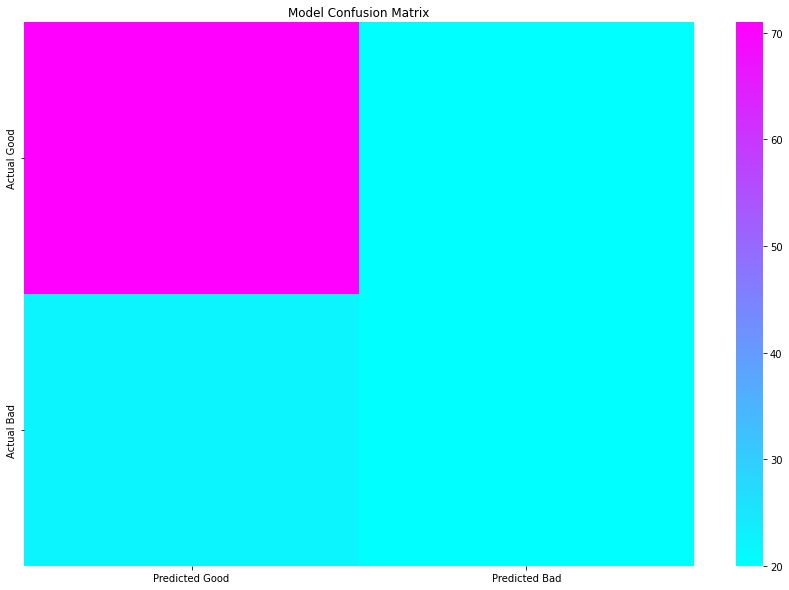

In [ ]:
# Classification Report
print('\n\n', classification_report(y_real, y_mod, target_names=['0-Good', '1-Bad']))
# Confusion Matrix
con_matrix = pd.DataFrame(confusion_matrix(y_real, y_mod), columns=['Predicted Good', 'Predicted Bad'], index=['Actual Good', 'Actual Bad'])
  
plt.figure(figsize=(15,10))
sns.heatmap(data=con_matrix, cmap='cool');
plt.title('Model Confusion Matrix')
plt.show()

In [ ]:
con_matrix 

,Predicted Good,Predicted Bad
Actual Good,71,20
Actual Bad,22,20


In [ ]:
prec = precision_score(y_real, y_mod)
rec = recall_score(y_real, y_mod)
f1 = f1_score(y_real, y_mod)
acc = accuracy_score(y_real, y_mod)
print('precision=',prec)
print('recall=',rec)
print('f1-score=',f1)
print('accuracy=',acc)

precision= 0.5
recall= 0.47619047619047616
f1-score= 0.4878048780487805
accuracy= 0.6842105263157895


## Birch:  Balanced Iterative Reducing and Clustering using Hierarchies

Considering metritcs found using KMeans method Birch unsupervised learning was used to create new features describing document title and job description in order to replace the features created using KMeans method

In [ ]:
model = Birch(n_clusters=2, threshold=0.01)
# fit the model
model.fit(Ws)
y_calc = model.predict(Ws)
y_mod = y_calc[index_no]
X_mod =Ws[index_no]



               precision    recall  f1-score   support

      0-Good       0.79      0.87      0.83        91
       1-Bad       0.64      0.50      0.56        42

    accuracy                           0.75       133
   macro avg       0.71      0.68      0.69       133
weighted avg       0.74      0.75      0.74       133



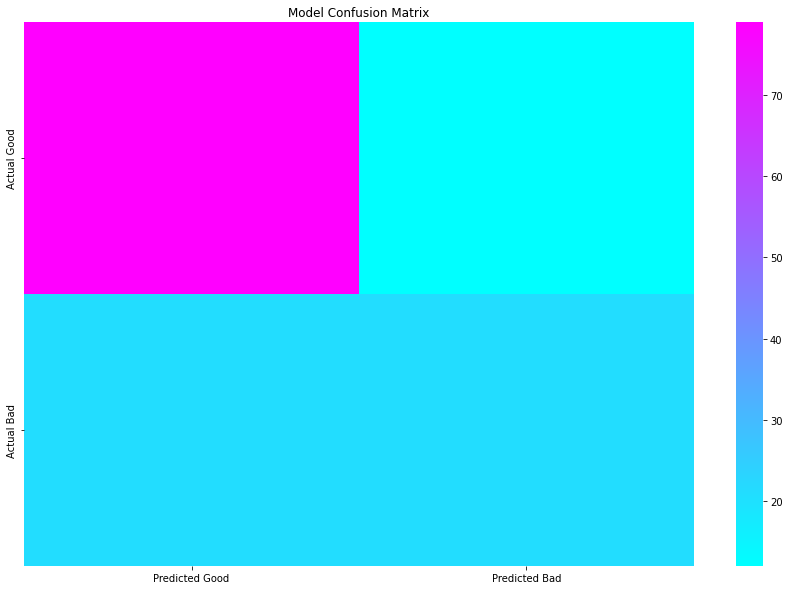

In [ ]:
# Classification Report
print('\n\n', classification_report(y_real, y_mod, target_names=['0-Good', '1-Bad']))
# Confusion Matrix
con_matrix = pd.DataFrame(confusion_matrix(y_real, y_mod), columns=['Predicted Good', 'Predicted Bad'], index=['Actual Good', 'Actual Bad'])
  
plt.figure(figsize=(15,10))
sns.heatmap(data=con_matrix, cmap='cool');
plt.title('Model Confusion Matrix')
plt.show();

In [ ]:
con_matrix 

,Predicted Good,Predicted Bad
Actual Good,79,12
Actual Bad,21,21


In [ ]:
prec = precision_score(y_real, y_mod)
rec = recall_score(y_real, y_mod)
f1 = f1_score(y_real, y_mod)
acc = accuracy_score(y_real, y_mod)
print('precision=',prec)
print('recall=',rec)
print('f1-score=',f1)
print('accuracy=',acc)

precision= 0.6363636363636364
recall= 0.5
f1-score= 0.56
accuracy= 0.7518796992481203


# Results discussion

As can be observed, BIRCH was more efficient  and more stable than kmeans and was selected to continue the analysis. As can be observed in the confusion matrix and in the picture, according with the labeled data,  the model has a good efficiency to classify good images, but is able to classify correctly only 50% of the bad images. If we include the feature "Num Resumes" and exclude " Height" the recall would improve 5%. But according to the  exploratory analysis and the small number of labeled points especially in category "Bad", I imagine the  exchange is not good. 
To improve the model I would label more data in order to test a supervised learning model. Also, would be good test new features and be more rigorous in feature selection and hyperparameter optimization.
 

# Exporting Results

In [ ]:
#y = data['Manual Label'].replace({'good':0, 'bad':1})
lista = []
for yi in y_calc:
  if(yi == 0):
    lista.append('good')
  else:
    lista.append('bad')

In [ ]:
df['Predict Label'] = lista

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [ ]:
Arq = "output_excel.xlsx"
df.to_excel(Arq)
files.download(Arq)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Arq = "output_csv.csv"
df.to_csv(Arq)
files.download(Arq)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>